# Distribution matching quantification experiments

This notebook allows to reproduce the results showed in [insert paper name]

## Preparation

In [1]:
import numpy as np
random_state = 42
np.random.seed(random_state)
import os, glob
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from quantification.metrics import binary_kl_divergence, absolute_error
from quantification.utils.validation import create_bags_with_multiple_prevalence

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter("ignore", DataConversionWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError
from sklearn.utils.extmath import softmax
from sklearn.ensemble import RandomForestClassifier

class LinearRegressionWrapper(LogisticRegression):
    """Class which overrides the sigmoid function of sklearn's LogisticRegression"""

    def __init__(self, alpha=1., penalty='l2', dual=False, tol=1e-4, C=1.0,
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0, warm_start=False, n_jobs=1):
        super(LinearRegressionWrapper, self).__init__(penalty, dual, tol, C, fit_intercept, intercept_scaling, class_weight, random_state, solver,
                         max_iter, multi_class, verbose, warm_start, n_jobs)
        self.alpha = alpha

    def _predict_proba(self, X):
        prob = self.decision_function(X)
        prob = -1 * prob * self.alpha
        np.exp(prob, prob)
        prob += 1
        np.reciprocal(prob, prob)
        if prob.ndim == 1:
            return np.vstack([1 - prob, prob]).T
        else:
            # OvR normalization, like LibLinear's predict_probability
            prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
            return prob

    def predict_proba(self, X):
        if not hasattr(self, "coef_"):
            raise NotFittedError("Call fit before prediction")
        calculate_ovr = self.coef_.shape[0] == 1 or self.multi_class == "ovr"
        if calculate_ovr:
            return self._predict_proba(X)
        else:
            return softmax(self.decision_function(X), copy=False)

In [4]:
def g_mean(clf, X, y):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, clf.predict(X), labels=clf.classes_)
    fpr = cm[0, 1] / float(cm[0, 1] + cm[0, 0])
    tpr = cm[1, 1] / float(cm[1, 1] + cm[1, 0])
    return np.sqrt((1 - fpr) * tpr)

## Datasets

In [5]:
datasets_dir = "datasets"
dataset_files = [file for file in glob.glob(os.path.join(datasets_dir, "*.csv")) if file not in ["datasets/balance.2.csv", "datasets/lettersG.csv", "datasets/k9.csv"]]
dataset_names = [os.path.split(name)[-1][:-4] for name in dataset_files]
print("There are a total of {} datasets.".format(len(dataset_names)))

There are a total of 41 datasets.


In [25]:
sorted(dataset_names).index("coil")

8

In [6]:
n_datasets = len(dataset_names)

columns=['dataset', 'method', 'truth', 'predictions', 'kld', 'mae']
errors_df = pd.DataFrame(columns=columns)

num_bags = 1000

## Utils

#### Standard scale data

In [7]:
from sklearn.preprocessing import StandardScaler

def normalize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


#### Load data

In [8]:
def load_data(dfile):
    df = pd.read_csv(dfile, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values.astype(np.int)
    if -1 in np.unique(y):
        y[y == -1] = 0
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=random_state)
    
    X_train, X_test = normalize(X_train, X_test)
    
    return X_train, X_test, y_train, y_test 

#### GridSearch parameters

In [9]:
estimator_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
#estimator_grid = {'C': [10 ** i for i in range(-3, 3)]}
grid_params = dict(verbose=False, scoring=g_mean)

In [11]:
errors_df = pd.read_csv("results_nonlinear_geometric_clf_1000bags.csv")
errors_df.groupby("method").count()

,dataset,truth,predictions,kld,mae
method,,,,,
EDX,41000,41000,41000,41000,41000
EDy,41000,41000,41000,41000,41000
HDX,41000,41000,41000,41000,41000
HDy,41000,41000,41000,41000,41000


## HDX

In [ ]:
from quantification.dm import HDX

hdx = HDX(b=8)

for dname, dfile in tqdm(zip(dataset_names, dataset_files), total=n_datasets):
        
    X_train, X_test, y_train, y_test = load_data(dfile)
    
    hdx.fit(X_train, y_train)
    for X_test_, y_test_, prev_true, in create_bags_with_multiple_prevalence(X_test, y_test, num_bags):
        prev_true = prev_true[1]
        prev_pred = hdx.predict(X_test_)[1]

        kld = binary_kl_divergence(prev_true, prev_pred)
        mae = absolute_error(prev_true, prev_pred)

        errors_df = errors_df.append(pd.DataFrame([[dname, 'HDX', prev_true, prev_pred, kld, mae]], columns=columns))
        
errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

## HDY

In [ ]:
from quantification.dm import HDy

hdy = HDy(b=8, estimator_class=RandomForestClassifier(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)
#hdy = HDy(b=8, estimator_class=LogisticRegression(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)


for dname, dfile in tqdm(zip(dataset_names, dataset_files), total=n_datasets):
            
    X_train, X_test, y_train, y_test = load_data(dfile)
    
    hdy.fit(X_train, y_train)
    for X_test_, y_test_, prev_true, in create_bags_with_multiple_prevalence(X_test, y_test, num_bags):
        prev_true = prev_true[1]
        prev_pred = hdy.predict(X_test_)[1]

        kld = binary_kl_divergence(prev_true, prev_pred)
        mae = absolute_error(prev_true, prev_pred)
    
        errors_df = errors_df.append(pd.DataFrame([[dname, 'HDy', prev_true, prev_pred, kld, mae]], columns=columns))
        
errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

## EDX

In [ ]:
from quantification.dm import EDx

edx = EDx()

for dname, dfile in tqdm(zip(dataset_names, dataset_files), total=n_datasets):
    
    X_train, X_test, y_train, y_test = load_data(dfile)
    
    edx.fit(X_train, y_train)
    for X_test_, y_test_, prev_true, in create_bags_with_multiple_prevalence(X_test, y_test, num_bags):
        prev_true = prev_true[1]
        try:
            prev_pred = edx.predict(X_test_)[1]
        except ValueError:
            errors_df = errors_df.append(pd.DataFrame([[dname, 'EDX', prev_true, np.nan, np.nan, np.nan]], columns=columns))
            continue
        kld = binary_kl_divergence(prev_true, prev_pred)  
        mae = absolute_error(prev_true, prev_pred)

        errors_df = errors_df.append(pd.DataFrame([[dname, 'EDX', prev_true, prev_pred, kld, mae]], columns=columns))

errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

## EDy

In [ ]:
from quantification.dm import EDy

edy = EDy(estimator_class=RandomForestClassifier(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)
#edy = EDy(estimator_class=LogisticRegression(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)
for dname, dfile in tqdm(zip(dataset_names, dataset_files), total=n_datasets):
    
    X_train, X_test, y_train, y_test = load_data(dfile)
    
    edy.fit(X_train, y_train)
    for X_test_, y_test_, prev_true, in create_bags_with_multiple_prevalence(X_test, y_test, num_bags):
        prev_true = prev_true[1]
        prev_pred = edy.predict(X_test_)[1]

        kld = binary_kl_divergence(prev_true, prev_pred)
        mae = absolute_error(prev_true, prev_pred)
 
        errors_df = errors_df.append(pd.DataFrame([[dname, 'EDy', prev_true, prev_pred, kld, mae]], columns=columns))

errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

## AC

In [12]:
from quantification.cc import AC

ac = AC(estimator_class=RandomForestClassifier(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)
#ac = AC(estimator_class=LogisticRegression(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)
for dname, dfile in tqdm(zip(dataset_names, dataset_files), total=n_datasets):
    
    X_train, X_test, y_train, y_test = load_data(dfile)
    
    ac.fit(X_train, y_train)
    for X_test_, y_test_, prev_true, in create_bags_with_multiple_prevalence(X_test, y_test, num_bags):
        prev_true = prev_true[1]
        prev_pred = ac.predict(X_test_)[1]

        kld = binary_kl_divergence(prev_true, prev_pred)
        mae = absolute_error(prev_true, prev_pred)
 
        errors_df = errors_df.append(pd.DataFrame([[dname, 'AC', prev_true, prev_pred, kld, mae]], columns=columns))
    
errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

100%|██████████| 41/41 [30:06<00:00, 44.06s/it]


## CvMy

In [ ]:
from quantification.dm import CvMy

# cvmy = CvMy(estimator_class=RandomForestClassifier(random_state=random_state, class_weight='balanced'))
cvmy = CvMy(estimator_class=RandomForestClassifier(random_state=random_state, class_weight='balanced'), estimator_grid=estimator_grid, grid_params=grid_params)
for dname, dfile in tqdm(zip(dataset_names, dataset_files), total=n_datasets):
    
    
    X_train, X_test, y_train, y_test = load_data(dfile)
    
    cvmy.fit(X_train, y_train)
    for X_test_, y_test_, prev_true, in create_bags_with_multiple_prevalence(X_test, y_test, num_bags):
        prev_true = prev_true[1]
        prev_pred = cvmy.predict(X_test_)[1]

        kld = binary_kl_divergence(prev_true, prev_pred)
        mae = absolute_error(prev_true, prev_pred)
 
        errors_df = errors_df.append(pd.DataFrame([[dname, 'CvMy', prev_true, prev_pred, kld, mae]], columns=columns))
    
errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

 83%|████████▎ | 34/41 [26:13<05:23, 46.27s/it]

# Resultados

## Errores

In [14]:
errors_df.reset_index(inplace=True, drop=True)

In [15]:
errors_df.groupby(['method'])[['kld', 'mae']].agg(['mean', 'median'])

kld             mae        
          mean  median    mean  median
method                                
AC     0.15923 0.00344 0.05677 0.03093
CvMy   0.24658 0.00590 0.06392 0.04053
EDX    0.03458 0.00391 0.05157 0.03349
EDy    0.15613 0.00361 0.05323 0.03187
HDX    0.03368 0.00453 0.06157 0.03603
HDy    0.04134 0.00283 0.05450 0.02786

In [16]:
# errors_df.kld[errors_df.kld > .1] = np.nan
# errors_df.mae[errors_df.mae > .1] = np.nan

In [ ]:
g = sns.FacetGrid(errors_df, row="method", row_order=errors_df.method.unique(),
                  size=1.7, aspect=4,)

_ = g.map(sns.kdeplot, "kld",  shade=True)
_ = g.map(sns.rugplot, "kld")

plt.subplots_adjust(top=0.9)
_ = g.fig.suptitle('KLD') # can also get the figure from plt.gcf()

In [ ]:
g = sns.FacetGrid(errors_df, row="method", row_order=errors_df.method.unique(),
                  size=1.7, aspect=4,)

_ = g.map(sns.kdeplot, "mae",  shade=True)
_ = g.map(sns.rugplot, "mae")

plt.subplots_adjust(top=0.9)
_ = g.fig.suptitle('MAE') # can also get the figure from plt.gcf()

## Predictions

In [ ]:
from bokeh.plotting import figure, output_notebook, show
import seaborn as sns
import itertools
output_notebook()

palette = sns.palettes.color_palette('colorblind', n_datasets)
colors = itertools.cycle(palette.as_hex())
p = figure(plot_width=800, plot_height=1400)

for dname, color in zip(dataset_names, colors):
    df = errors_df[np.logical_and(errors_df.dataset==dname, errors_df.method=="HDy")]
    p.scatter(df['truth'], df['mae'], color=color, legend=dname)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)


In [ ]:
errors_df.groupby(["dataset"])["kld", "mae"].describe()

In [ ]:
mae_df = errors_df.pivot_table(index=['dataset'], 
                    columns='method', 
                    aggfunc=np.mean, 
                    values='mae', 
                    fill_value=0)
mae_df


In [ ]:
errors_df.to_csv("results_nonlinear_geometric_clf_1000bags.csv", index=None)

In [ ]:
errors_df.method.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'figure'

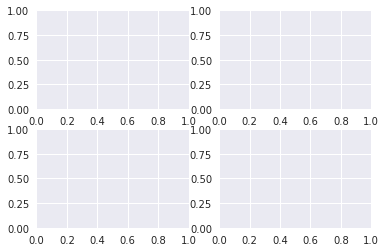

In [33]:
fig2, axs2 = plt.subplots(2,2)
axs2.figure
axs2 = np.array([axs[0][1], axs[2][3], axs[1][4], axs[3][4]])
axs2.figure = fig2
